In [1]:
from hypyflow import blocks, PreprocessingPipeline
from scipy.io import loadmat
import numpy as np
import os

os.chdir("/home/arturo.samayor/Practicas/hyperspectralpreprocessor-main")
number = 1111
cube_path = f"/home/arturo.samayor/Practicas/HeiPorSPECTRAL_example/intermediates/preprocessing/L1/P086#2021_04_15_09_22_02.blosc"
#cube_path = f"/home/arturo.samayor/Practicas/HS-Images/Headwall/ID_183_CN_1_Headwall Linescan/LINEimagesID000183C01_cropped_Pre-processed.mat"
#cube = loadmat(cube_path)["CI_cube"]
#cube = np.load(f"/home/arturo.samayor/Practicas/HS_Images/Datos_Arturo/data/mano_lejos{number}_cube.npy")

#cube = np.load(cube_path.read_cube())

#cube=np.clip(cube,0,1)

                     _____                                                                    _____ 
                    ( ___ )------------------------------------------------------------------( ___ )
                     |   |                                                                    |   | 
                     |   |  ██░ ██▓██   ██▓ ██▓███ ▓██   ██▓  █████▒██▓     ▒█████   █     █░ |   | 
                     |   | ▓██░ ██▒▒██  ██▒▓██░  ██▒▒██  ██▒▓██   ▒▓██▒    ▒██▒  ██▒▓█░ █ ░█░ |   | 
                     |   | ▒██▀▀██░ ▒██ ██░▓██░ ██▓▒ ▒██ ██░▒████ ░▒██░    ▒██░  ██▒▒█░ █ ░█  |   | 
                     |   | ░▓█ ░██  ░ ▐██▓░▒██▄█▓▒ ▒ ░ ▐██▓░░▓█▒  ░▒██░    ▒██   ██░░█░ █ ░█  |   | 
                     |   | ░▓█▒░██▓ ░ ██▒▓░▒██▒ ░  ░ ░ ██▒▓░░▒█░   ░██████▒░ ████▓▒░░░██▒██▓  |   | 
                     |   |  ▒ ░░▒░▒  ██▒▒▒ ▒▓▒░ ░  ░  ██▒▒▒  ▒ ░   ░ ▒░▓  ░░ ▒░▒░▒░ ░ ▓░▒ ▒   |   | 
                     |   |  ▒ ░▒░ ░▓██ ░▒░ ░▒ ░     ▓██ ░▒░  ░     ░ ░ ▒  ░  ░ ▒ ▒░   ▒ ░ ░

In [2]:
import os

# Configurar la variable de entorno
os.environ["PATH_Tivita_HeiPorSPECTRAL"] = "/home/arturo.samayor/Practicas/HeiPorSPECTRAL_example"

# Verificar que está configurada correctamente
print(os.environ.get("PATH_Tivita_HeiPorSPECTRAL"))


/home/arturo.samayor/Practicas/HeiPorSPECTRAL_example


In [3]:
from htc import DataPath, LabelMapping

# You can load every image based on its unique name
path = DataPath.from_image_name('P086#2021_04_15_09_22_02')
#obj = DataPath(image_dir = None, data_dir="/home/arturo.samayor/Practicas/HeiPorSPECTRAL_example")
#path = obj.from_image_name('P086#2021_04_15_09_22_02')

# HSI cube format: (height, width, channels)
print(path.read_cube().shape)
cube = path.read_cube()
#np.save('/home/arturo.samayor/Practicas/NNs/cubo.npy', cube)

(480, 640, 100)


COSAS DE ALEJANDRO

In [4]:
# First let's visualize the information!
# from hypyflow import HyperspectralViewer, constants

# wavelenghts=constants.HEADWALL_VNIR_WAVELENGHTS
# # Create and run the viewer
# viewer = HyperspectralViewer(cube, wavelenghts)
# viewer.run()

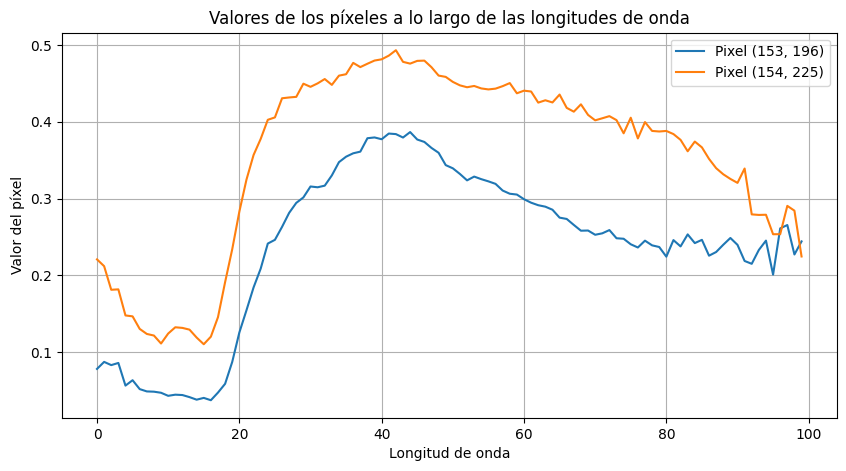

In [5]:
# quiero mostrar un plot con los valores de los píxeles 153, 196; 154, 225
import matplotlib.pyplot as plt
import numpy as np
# Definir las coordenadas de los píxeles
x1, y1 = 153, 196
x2, y2 = 154, 225
# Obtener los valores de los píxeles
pixel_values1 = cube[x1, y1, :]
pixel_values2 = cube[x2, y2, :]
# Crear un gráfico
plt.figure(figsize=(10, 5))
plt.plot(pixel_values1, label=f'Pixel ({x1}, {y1})')
plt.plot(pixel_values2, label=f'Pixel ({x2}, {y2})')
plt.title('Valores de los píxeles a lo largo de las longitudes de onda')
plt.xlabel('Longitud de onda')
plt.ylabel('Valor del píxel')
plt.legend()
plt.grid()
plt.show()


 - Using previous mask, skipping masking blocks


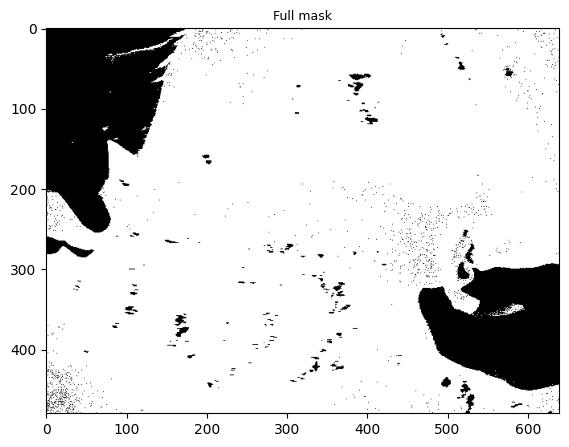

In [6]:
# hago que la variable cube, en lugar de la tercera dimension tener 369 dimensiones, tenga desde la 100 hasta la 369
#cube = cube[:,:,100:369]


preprocesschain = [
    blocks.MaskNegativeValues(),
    blocks.MaskZeroValues(),
    blocks.MaskSaturatedValues(99.5), #
    #blocks.ProcessNormalize(type="MinMax"),#
    blocks.ProcessDenoise(),
    blocks.MaskRxAnomalyDetection(0.2), #
    #blocks.MaskTargetSignature(interactive=True,select_area=True,method="SC"), #TODO: hacer que la barra selectora sea logarítmica, para que cuando me acerque a 0.1 no sea tan dificil seleccionar
    #blocks.MaskTargetSignature(interactive=True,select_area=True,method="SAM"),
    blocks.ProcessSmoothSpectral("moving_average", params={"window_size": 3}),#(method="moving_average", params={"window_size": 3}),
    blocks.ProcessSmoothSpatial()
]

try:
    if os.path.exists(f"/home/arturo.samayor/Practicas/data/masks_{number}head.npy"):# and "headwall" in cube_path.lower():
        full_mask = np.load(f"/home/arturo.samayor/Practicas/data/masks_{number}head.npy")
    elif os.path.exists(f"/home/arturo.samayor/Practicas/data/masks_{number}.npy") and "snapshot" in cube_path.lower():
        full_mask = np.load(f"/home/arturo.samayor/Practicas/data/masks_{number}.npy")
    else: full_mask = None
    masks = None
except:
    full_mask = None
    masks = None
pre = PreprocessingPipeline(cube)
filtered_data, full_mask, masks = pre(preprocesschain, verbose=False, plot_masks=True, mask=full_mask) # donde full_mask es la mascara final

np.save(f"/home/arturo.samayor/Practicas/data/masks_{number}head.npy", full_mask)

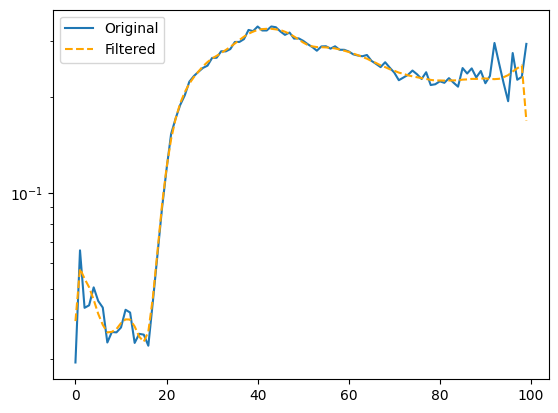

In [7]:
import matplotlib.pyplot as plt
pixels_to_plot = [(295, 146), (100, 200), (150, 200)]
plt.plot(cube[100,200,0:100], label='Original')
plt.plot(filtered_data[100,200,0:100], label='Filtered', color='orange', linestyle='--')
plt.yscale('log')
#plt.xlim(0,20)
plt.legend()
plt.show()


## Obtención de Valores de Hb y HbO2

[WARNING][py.warnings] /tmp/ipykernel_2573847/1338571393.py:195: FutureWarning: The 'delim_whitespace'   warnings.py:110
keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead                 
  data =                                                                                                                
pd.read_csv("/home/arturo.samayor/Practicas/StO2_arturo/data/spectral_signs/Spectra_1A/cytochrome_c_oxid                
ase.txt", delim_whitespace=True, header=None, names=["Wavelength","ox_cyt_c_oxidase",                                   
"red_cyt_c_oxidased"], skiprows=1)                                                                                      
                                                                                                                        

[WARNING][py.warnings] /tmp/ipykernel_2573847/1338571393.py:201: FutureWarning: The 'delim_whitespace'   warnings.py:110
keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead                 
  dataF =                                                                                                               
pd.read_csv("/home/arturo.samayor/Practicas/StO2_arturo/data/spectral_signs/Spectra_1A/fat.txt",                        
delim_whitespace=True, header=None, names=["Wavelength","Fat"], skiprows=1)                                             
                                                                                                                        

Interpolación 'ox_cyt_c_oxidase' completada. Nueva longitud: 100
Interpolación 'red_cyt_c_oxidased' completada. Nueva longitud: 100
[+] La primera longitud de onda de la señal oxidada es: 500.0 y la última es: 1000.0
tamaño de ox_cyt_c_oxidase: 483
tamaño de red_cyt_c_oxidased: 483


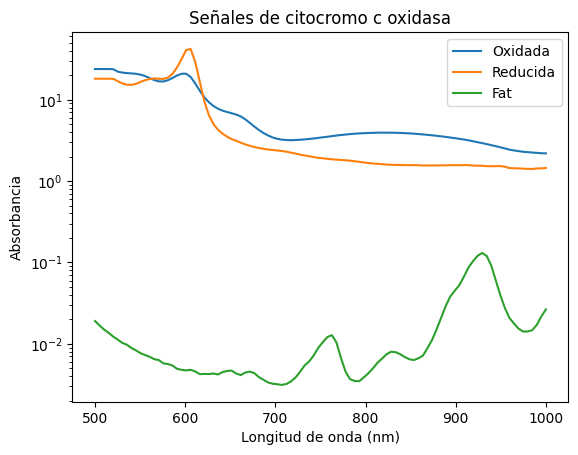

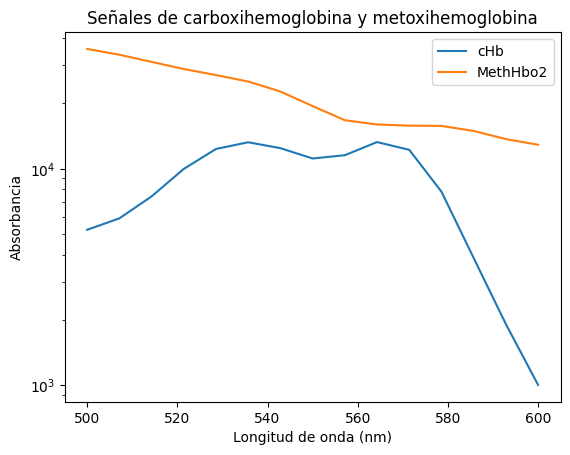

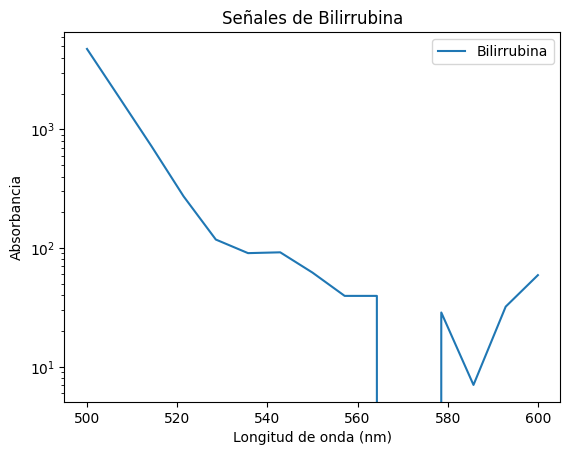

media de hb_sign: 48.55836528750001
media de hbO2_sign: 39.599711174999996
media de other_sign_new: 72983.5550505047
media de hb_concatenated: 223.91951532866668
media de hbo2_concatenated: 201.5640016526667
valor máximo del cubo en process_intervals_and_normalize: 2.231651
media de ox_cyt_c_oxidase: 19.518352525925923
media de red_cyt_c_oxidase: 18.745452185185187
media de fat: 0.007317185185185185

media de hb_concatenated: 223.91951532866668
media de hbo2_concatenated: 201.5640016526667
media de other_concatenated: 804.6464646473333
Longitud de hb_concatenated: 15
Longitud de hbo2_concatenated: 15
Longitud de other_concatenated: 15
Longitud de ox_cyt_c_oxidase: 15
Longitud de red_cyt_c_oxidase: 15
Longitud de fat: 15
Longitud de carboxyhemoglobin_sign: 20
Longitud de methoxyhemoglobin_sign: 20
Formas - hb_sign: (100,) hbO2_sign: (100,) filtered_data: (480, 640, 15)
La media del cubo enmascarado es: 1.49805748462677
El valor máximo del cubo enmascarado es: 23.80818748474121 y el valo

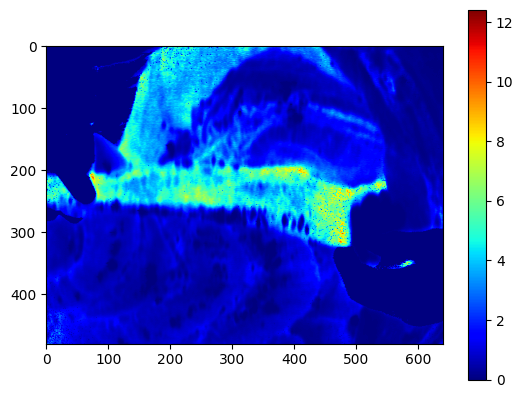

  0%|          | 0/480 [00:00<?, ?it/s]

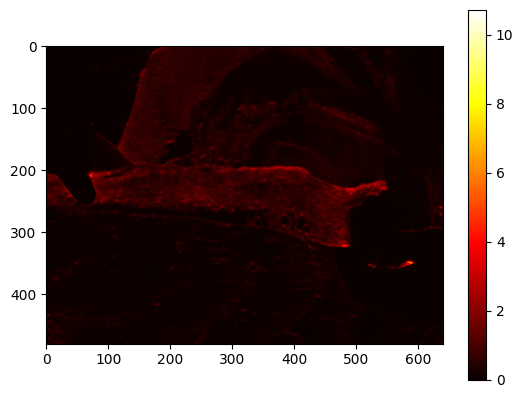

Hb min/max: 0.0 0.029394876039068894
HbO2 min/max: 0.0 0.025740877412555242
media de ab_hb: 0.0016769770847210401
media de ab_hbo2: 0.003240625052157973


In [30]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
import scipy
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm.auto import tqdm, trange

# ============================================================== #
# [+] Funciones auxiliares
# ============================================================== #
def SAM(data: np.ndarray, signature: np.ndarray):
    """
    Spectral Angle Mapper.
    Computes the angle between two spectra, the result is a value between 0 and pi/2m the smaller the value, the more similar the spectra are.
    Args:
        data (np.ndarray): The hyperspectral data cube. The shape of the data must be (n_rows, n_cols, n_bands)
        signature (np.ndarray): The spectral signature to compare. The shape of the signature must be (n_bands,)
        threshold (float): The threshold to create the mask
    Returns:
        np.ndarray: The image with the spectral angle values
        np.ndarray: The mask with the pixels that are similar to the signature
    """
    spectral_angle = np.arccos(np.sum(signature * data) / (np.linalg.norm(signature) * np.linalg.norm(data)))
    #print(f"El valor de la función SAM es: {spectral_angle}")
    return spectral_angle


def from_reflectance_to_absorbance(data_reflectance):
    data_reflectance = data_reflectance#/np.max(data_reflectance)
    epsilon = 1e-10  # Un valor pequeño para evitar el logaritmo de cero
    reflectance = np.clip(data_reflectance, epsilon, np.max(data_reflectance))  # Recorta los valores entre epsilon y 1
    absorbance = -np.log10(reflectance)
    return absorbance

# Método de aplicación de la máscara
def apply_mask(data, mask):
    masked_data = np.zeros_like(data)
    for i in range(data.shape[2]):
        masked_data[:, :, i] = np.where(mask, data[:, :, i], 0)
    return masked_data

# en este método, a todos los valores se le sumará el valor absoluto del valor mínimo
# para que todos los valores sean positivos
def always_positive(data):
    return data + np.abs(np.min(data))

def concatenate_and_normalize(sign, intervals):
    """
    Concatenar y normalizar señales espectrales en intervalos específicos.

    Args:
        sign (numpy.ndarray): Señal de un compuesto.
        intervals (list of tuples): Lista de intervalos de longitud de onda [(inicio, fin), ...]

    Returns:
        tuple: Arrays concatenados y normalizados (final_sign).
    """
    def normalize(data):
        return (data) #/ max
    
    final_sign = []
    start = intervals[0][0]
    end = intervals[-1][1]
    # compruebo cuál de los signos tiene el valor máximo más altos dentro del intervalo
    max_hb = np.max(hb_sign[start:end])
    max_hbo2 = np.max(hbO2_sign[start:end])
    max_other = np.max(other_sign_new[start:end])
    
    '''if max_hb > max_hbo2 and max_hb > max_other:
        print(f"El signo con el valor máximo más alto en el intervalo {start}-{end} es hb_sign con un valor de {max_hb}")
        max = max_hb
    elif max_hbo2 > max_hb and max_hbo2 > max_other:
        print(f"El signo con el valor máximo más alto en el intervalo {start}-{end} es hbO2_sign con un valor de {max_hbo2}")
        max = max_hbo2
    else:
        print(f"El signo con el valor máximo más alto en el intervalo {start}-{end} es other_sign_new con un valor de {max_other}")
        max = max_other'''
    max = max_hbo2
    
    for start, end in intervals:
        sign_segment = normalize(sign[start:end])
        
        final_sign.append(sign_segment)
    
    # Concatenar los segmentos normalizados
    final_sign = np.concatenate(final_sign)
    
    return final_sign

def process_intervals_and_normalize(masked_cube, intervals, max):
    """
    Normaliza y concatena las partes del cubo hiperespectral definidas por los intervalos.

    Args:
        masked_cube (numpy.ndarray): Cubo hiperespectral de entrada (alto, ancho, bandas).
        intervals (list of tuples): Lista de intervalos (inicio, fin) que definen las bandas a procesar.

    Returns:
        numpy.ndarray: Cubo hiperespectral normalizado y concatenado.
    """
    processed_parts = []
    print("valor máximo del cubo en process_intervals_and_normalize:", np.max(masked_cube))

    for start, end in intervals:
        # Seleccionar las bandas correspondientes al intervalo
        cube_part = masked_cube[:, :, start:end]
        
        # Normalizar el intervalo
        #cube_part_normalized = (cube_part - np.min(cube_part)) / (np.max(cube_part) - np.min(cube_part))
        #cube_part_normalized = cube_part/np.max(cube_part)
        cube_part_normalized = cube_part#/max

        # Agregar la parte normalizada a la lista
        processed_parts.append(cube_part_normalized)

    # Concatenar todas las partes a lo largo del eje de las bandas
    concatenated_cube = np.concatenate(processed_parts, axis=2)

    return concatenated_cube


def interpolate_spectrum(original_wavelengths, original_values, target_min_wl=500, target_max_wl=1000, num_points=100):
    """
    Interpola datos espectrales a un nuevo conjunto de longitudes de onda especificadas.

    Esta función toma un espectro definido por sus longitudes de onda y valores originales,
    y devuelve un nuevo espectro interpolado en un número específico de puntos
    distribuidos uniformemente dentro de un rango de longitud de onda objetivo.

    Args:
        original_wavelengths (np.ndarray or list-like): Array o lista de las longitudes de onda originales.
        original_values (np.ndarray or list-like): Array o lista de los valores espectrales correspondientes
                                                    a las longitudes de onda originales.
        target_min_wl (float, optional): Longitud de onda mínima del nuevo conjunto interpolado.
                                        Por defecto es 500.
        target_max_wl (float, optional): Longitud de onda máxima del nuevo conjunto interpolado.
                                        Por defecto es 1000.
        num_points (int, optional): Número de puntos (longitudes de onda) deseado en el
                                    nuevo conjunto interpolado. Por defecto es 100.

    Returns:
        tuple: Una tupla conteniendo dos arrays de NumPy:
            - target_wavelengths (np.ndarray): El nuevo array de longitudes de onda, con 'num_points'
                                            elementos espaciados uniformemente entre 'target_min_wl'
                                            y 'target_max_wl'.
            - interpolated_values (np.ndarray): El array de valores espectrales interpolados
                                                correspondientes a 'target_wavelengths'.
    Raises:
        ValueError: Si las longitudes de los arrays de entrada no coinciden o si
                    los datos de entrada no son adecuados para la interpolación.
    """
    # Asegurarse de que los datos de entrada son arrays de numpy y tienen la misma longitud
    original_wavelengths = np.asarray(original_wavelengths)
    original_values = np.asarray(original_values)

    if original_wavelengths.shape != original_values.shape or original_wavelengths.ndim != 1:
        raise ValueError("Las longitudes de onda y los valores originales deben ser arrays 1D de la misma longitud.")
    if len(original_wavelengths) < 2:
        raise ValueError("Se necesitan al menos dos puntos de datos para la interpolación.")

    # Crear el nuevo eje de longitudes de onda objetivo
    target_wavelengths = np.linspace(target_min_wl, target_max_wl, num_points)

    # Crear la función de interpolación lineal
    # kind='linear' es una opción robusta. Se podría usar 'cubic' para mayor suavidad si los datos lo permiten.
    # bounds_error=False evita errores si target_wavelengths está ligeramente fuera del rango original,
    # fill_value="extrapolate" intentará extrapolar en esos casos.
    try:
        interp_func = interp1d(original_wavelengths, original_values,
                                kind='linear',
                                bounds_error=False,
                                fill_value="extrapolate")
    except ValueError as e:
        raise ValueError(f"Error al crear la función de interpolación: {e}. Verifica que las longitudes de onda originales estén ordenadas.") from e

    # Calcular los valores interpolados en las longitudes de onda objetivo
    interpolated_values = interp_func(target_wavelengths)

    return target_wavelengths, interpolated_values


# ============================================================== #

# ============================================================== #
# [+] Carga de las signaturas de los compuestos y normalización
# ============================================================== #

hb_sign = np.loadtxt("/home/arturo.samayor/Practicas/StO2_arturo/data/spectral_signs/hb_sign_reduced.txt")[:, 1]
hbO2_sign = np.loadtxt("/home/arturo.samayor/Practicas/StO2_arturo/data/spectral_signs/hbo2_sign_reduced.txt")[:, 1]
other_sign_new = np.loadtxt("/home/arturo.samayor/Practicas/StO2_arturo/data/spectral_signs/extintion Coefficient Pigs/agua/agua_absorcionFinal.csv")[:, 1]

#cyt
data = pd.read_csv("/home/arturo.samayor/Practicas/StO2_arturo/data/spectral_signs/Spectra_1A/cytochrome_c_oxidase.txt", delim_whitespace=True, header=None, names=["Wavelength","ox_cyt_c_oxidase", "red_cyt_c_oxidased"], skiprows=1)
data["ox_cyt_c_oxidase"] = pd.to_numeric(data["ox_cyt_c_oxidase"], errors="coerce")
data["red_cyt_c_oxidased"] = pd.to_numeric(data["red_cyt_c_oxidased"], errors="coerce")
data["Wavelength"] = pd.to_numeric(data["Wavelength"], errors="coerce")

# FAT
dataF = pd.read_csv("/home/arturo.samayor/Practicas/StO2_arturo/data/spectral_signs/Spectra_1A/fat.txt", delim_whitespace=True, header=None, names=["Wavelength","Fat"], skiprows=1)
dataF["Wavelength"] = pd.to_numeric(dataF["Wavelength"], errors="coerce")
dataF["Fat"] = pd.to_numeric(dataF["Fat"], errors="coerce")

wavelengths_fat = dataF["Wavelength"].to_numpy()
fat_values = dataF["Fat"].to_numpy()/100

#hbs
carboxyhemoglobin_sign = np.loadtxt("/home/arturo.samayor/Practicas/StO2_arturo/data/spectral_signs/othersHB/carboxyHb.txt", delimiter=",")[:, 1]
methoxyhemoglobin_sign = np.loadtxt("/home/arturo.samayor/Practicas/StO2_arturo/data/spectral_signs/othersHB/MethHb.txt", delimiter=",")[:, 1]

# bilirubin
bilirubin_sign = np.loadtxt("/home/arturo.samayor/Practicas/StO2_arturo/data/spectral_signs/bilirubin/bilirubin.csv", delimiter=" ")[:, 1]
wavelengths_bilirubin = np.loadtxt("/home/arturo.samayor/Practicas/StO2_arturo/data/spectral_signs/bilirubin/bilirubin.csv", delimiter=" ")[:, 0]

# sulfhemoglobin
sulfhemoglobin_sign = np.loadtxt("/home/arturo.samayor/Practicas/StO2_arturo/data/spectral_signs/sulfhemoglobin/sulfhemoglobin.txt", delimiter=",")[:, 1]
wavelengths_sulfhemoglobin = np.loadtxt("/home/arturo.samayor/Practicas/StO2_arturo/data/spectral_signs/sulfhemoglobin/sulfhemoglobin.txt", delimiter=",")[:, 0]

# --- Interpolación --- cyt
    # Interpolar la señal 'oxidada' para tener 100 puntos entre 500 y 1000 nm
target_wl_100, interp_ox_100 = interpolate_spectrum(data["Wavelength"], data["ox_cyt_c_oxidase"],
                                                    target_min_wl=500, target_max_wl=1000, num_points=100)
print(f"Interpolación 'ox_cyt_c_oxidase' completada. Nueva longitud: {len(interp_ox_100)}")

# Interpolar la señal 'reducida' usando las mismas longitudes de onda objetivo
_, interp_red_100 = interpolate_spectrum(data["Wavelength"], data["red_cyt_c_oxidased"],
                                        target_min_wl=500, target_max_wl=1000, num_points=100)

# interlpolación FAT
_, interp_fat_100 = interpolate_spectrum(wavelengths_fat, fat_values,
                                        target_min_wl=500, target_max_wl=1000, num_points=100)


# Suponiendo que carboxyhemoglobin_sign tiene 20 puntos
original_wl_carboxy = np.linspace(500, 600, len(carboxyhemoglobin_sign))
target_wl_carboxy, interp_carboxyhemoglobin_sign = interpolate_spectrum(
    original_wl_carboxy,
    carboxyhemoglobin_sign,
    target_min_wl=500,
    target_max_wl=600,
    num_points=15
)
# interpolación methoxyhemoglobin_sign, como ya tengo directamente en el archivo las longitudes de onda de 600 a 1000, tengo que interpolar dado
# que en lugar de tener 15 puntos, tengo 20, y quiero 15 puntos
original_wl_methoxy = np.linspace(500, 600, len(methoxyhemoglobin_sign))
target_wl_methoxy, interp_methoxyhemoglobin_sign = interpolate_spectrum(
    original_wl_methoxy,
    methoxyhemoglobin_sign,
    target_min_wl=500,
    target_max_wl=600,
    num_points=15
)

# interpolación de bilirubina
original_wl_bilirubin = np.linspace(500, 600, len(bilirubin_sign))
target_wl_bilirubin, interp_bilirubin_sign = interpolate_spectrum(
    original_wl_bilirubin,
    bilirubin_sign,
    target_min_wl=500,
    target_max_wl=600,
    num_points=15
)

# interpolación de sulfhemoglobina
original_wl_sulfhemoglobin = np.linspace(500, 600, len(sulfhemoglobin_sign))
target_wl_sulfhemoglobin, interp_sulfhemoglobin_sign = interpolate_spectrum(
    original_wl_sulfhemoglobin,
    sulfhemoglobin_sign,
    target_min_wl=500,
    target_max_wl=600,
    num_points=15
)

print(f"Interpolación 'red_cyt_c_oxidased' completada. Nueva longitud: {len(interp_red_100)}")
print("[+] La primera longitud de onda de la señal oxidada es:", target_wl_100[0], "y la última es:", target_wl_100[-1])
print("tamaño de ox_cyt_c_oxidase:", len(data["ox_cyt_c_oxidase"]))
print("tamaño de red_cyt_c_oxidased:", len(data["red_cyt_c_oxidased"]))
# muestro una gráfica de la señal oxidada y reducida
plt.plot(target_wl_100, interp_ox_100, label="Oxidada")
plt.plot(target_wl_100, interp_red_100, label="Reducida")
plt.plot(target_wl_100, interp_fat_100, label="Fat")
plt.xlabel("Longitud de onda (nm)")
plt.ylabel("Absorbancia")
plt.yscale("log")
plt.title("Señales de citocromo c oxidasa")
plt.legend()
plt.show()

plt.figure()
plt.plot(target_wl_carboxy, interp_carboxyhemoglobin_sign, label="cHb")
plt.plot(target_wl_methoxy, interp_methoxyhemoglobin_sign, label="MethHbo2")
plt.xlabel("Longitud de onda (nm)")
plt.ylabel("Absorbancia")
plt.yscale("log")
plt.title("Señales de carboxihemoglobina y metoxihemoglobina")
plt.legend()
plt.show()


plt.figure()
plt.plot(target_wl_bilirubin, interp_bilirubin_sign, label="Bilirrubina")
plt.xlabel("Longitud de onda (nm)")
plt.ylabel("Absorbancia")
plt.yscale("log")
plt.title("Señales de Bilirrubina")
plt.legend()
plt.show()


print(f"media de hb_sign: {np.mean(hb_sign)}")
print(f"media de hbO2_sign: {np.mean(hbO2_sign)}")
print(f"media de other_sign_new: {np.mean(other_sign_new)}")
# ============================================================== #

# ============================================================== #
# [+] Cálculo de las abundancias y aplicación de la máscara
# ============================================================== #
filtered_data_absorbance = from_reflectance_to_absorbance(filtered_data)#filtered_data  # CUBO DE HEIPORSPECTRAL ESTÁ MEDIDO EN ABSORBANCIA
masked_cube = apply_mask(filtered_data_absorbance, full_mask)


intervals = [(5, 20)] # 500-1000 nm (variaciones finales útiles para análisis)


# Define tus intervalos de longitud de onda

max = np.max(hbO2_sign)
hb_concatenated = concatenate_and_normalize(hb_sign, intervals)
hbo2_concatenated = concatenate_and_normalize(hbO2_sign, intervals)
print("media de hb_concatenated:", np.mean(hb_concatenated))
print("media de hbo2_concatenated:", np.mean(hbo2_concatenated))
other_concatenated = concatenate_and_normalize(other_sign_new, intervals)
masked_cube = process_intervals_and_normalize(masked_cube, intervals, max)
masked_cube = masked_cube**4

ox_cyt_c_oxidase = concatenate_and_normalize(interp_ox_100, intervals)
red_cyt_c_oxidase = concatenate_and_normalize(interp_red_100, intervals)
print("media de ox_cyt_c_oxidase:", np.mean(ox_cyt_c_oxidase))
print("media de red_cyt_c_oxidase:", np.mean(red_cyt_c_oxidase))

fat = concatenate_and_normalize(interp_fat_100, intervals)
print("media de fat:", np.mean(fat))


print(f"\nmedia de hb_concatenated: {np.mean(hb_concatenated)}")
print(f"media de hbo2_concatenated: {np.mean(hbo2_concatenated)}")
print(f"media de other_concatenated: {np.mean(other_concatenated)}")

# voy a hacer el concatenate y normalize de masked_cube
#masked_cube_500_600 = (masked_cube[:,:,0:20] - np.min(masked_cube[:,:,0:20])) / (np.max(masked_cube[:,:,0:20]) - np.min(masked_cube[:,:,0:20]))
#masked_cube_600_1000 = (masked_cube[:,:,20:100] - np.min(masked_cube[:,:,20:100])) / (np.max(masked_cube[:,:,20:100]) - np.min(masked_cube[:,:,20:100]))

#masked_cube = np.concatenate((masked_cube_500_600, masked_cube_600_1000), axis=2)'''

print("Longitud de hb_concatenated:", len(hb_concatenated))
print("Longitud de hbo2_concatenated:", len(hbo2_concatenated))
print("Longitud de other_concatenated:", len(other_concatenated))
print("Longitud de ox_cyt_c_oxidase:", len(ox_cyt_c_oxidase))
print("Longitud de red_cyt_c_oxidase:", len(red_cyt_c_oxidase))
print("Longitud de fat:", len(fat))
print("Longitud de carboxyhemoglobin_sign:", len(carboxyhemoglobin_sign))
print("Longitud de methoxyhemoglobin_sign:", len(methoxyhemoglobin_sign))
#masked_cube = always_positive(masked_cube)
# ============================================================== #

# ============================================================== #
# [+] Caso en el que queramos reducir la cantidad de datos
# ============================================================== #
#masked_cube = masked_cube[:,:,20:]
new_masked_cube = masked_cube# - np.min(masked_cube)) / (np.max(masked_cube) - np.min(masked_cube))# LO ULTIMO QUE HAGO
hb_sign_new = hb_concatenated
hbO2_sign_new = hbo2_concatenated
other_sign_new = other_concatenated
# ============================================================== #

# ============================================================== #
# [+] Visualización de forma de los datos
# ============================================================== #
height, width, bands = masked_cube.shape
print("Formas - hb_sign:", hb_sign.shape, "hbO2_sign:", hbO2_sign.shape, "filtered_data:", masked_cube.shape)
print(f"La media del cubo enmascarado es: {np.mean(new_masked_cube)}")
print(f"El valor máximo del cubo enmascarado es: {np.max(new_masked_cube)} y el valor mínimo es: {np.min(new_masked_cube)}")
plt.imshow(masked_cube[:, :, 0], cmap="jet")
plt.colorbar()
plt.show()

######################### CHATGPT #########################
#other_sign = np.ones_like(hb_sign)
#other_sign = (other_sign - np.min(other_sign)) / (np.max(other_sign) - np.min(other_sign))
#other_sign_new = other_sign
ab_other = np.zeros((height, width))
def residuals(x, pixel, hb_sign, hbo2_sign, other_sign):
    ab_hb, ab_hbo2, ab_other = x  # x es un vector con tres elementos: ab_hb, ab_hbo2 y ab_other
    model = ab_hb * hb_sign + ab_hbo2 * hbo2_sign + ab_other * other_sign  # Modelo lineal de absorbancia
    #return RMSE(pixel, model)
    return pixel - model  # Residuos: diferencia entre lo observado y lo modelado
######################### CHATGPT #########################


# ============================================================== #

# ============================================================== #
# [+] Inicialización de las matrices de abundancias
# ============================================================== #
ab_hb = np.zeros((height, width))
ab_hbo2 = np.zeros((height, width))
ab_ox = np.zeros((height, width))
ab_red = np.zeros((height, width))
ab_fat = np.zeros((height, width))
ab_carboxy = np.zeros((height, width))
ab_methoxy = np.zeros((height, width))
ab_bilirubin = np.zeros((height, width))
ab_sulfhemoglobin = np.zeros((height, width))
ab_syn = np.zeros((height, width))
error = np.zeros((height, width))
# ============================================================== #

# ============================================================== #
# [+] Función de residuos y optimización de las abundancias
# ============================================================== #
def residuals(x, pixel, hb_sign, hbo2_sign, other_sign):
    ab_hb, ab_hbo2, ab_other = x  # x es un vector con dos elementos: ab_hb y ab_hbo2
    model = ab_hb * hb_sign + ab_hbo2 * hbo2_sign + ab_other * other_sign  # Modelo lineal de absorbancia
    #return (pixel - model)**2  # Residuos: diferencia entre lo observado y lo modelado
    return RMSE(pixel, model)

def RMSE(y1, y2):
    return np.sqrt(np.mean((y1 - y2) ** 2))

'''def residuals_with_regularization(x, pixel, hb_sign, hbO2_sign, other_sign, lambda_reg=0.01):
    ab_hb, ab_hbo2, ab_other = x
    model = ab_hb * hb_sign + ab_hbo2 * hbO2_sign + ab_other * other_sign
    residual = pixel - model
    # Penalización L1 (Lasso)
    penalty = lambda_reg * (np.sum(np.abs(x)))
    # O penalización L2 (Ridge)
    # penalty = lambda_reg * np.sum(x**2)
    return np.sum(residual**2) + penalty  # Sumamos la penalización'''
    
def residuals_with_regularization_and_loss_sam(
    x, pixel, hb_sign, hbO2_sign, other_sign, lambda_reg=0.01, lambda_sam=0.1
):
    ab_hb, ab_hbo2, ab_other = x
    model = ab_hb * hb_sign + ab_hbo2 * hbO2_sign + ab_other * other_sign

    residual = pixel - model
    sam_cost = loss_SAM(x, pixel, hb_sign, hbO2_sign, other_sign)

    # Combina el residuo y el SAM en un solo vector.
    combined_residual = np.concatenate((residual, [sam_cost]))

    return combined_residual # Solo devuelve combined_residual

# --- Jacobiano (NUEVO) ---
def jacobian_with_regularization(
    x, pixel, hb_sign, hbO2_sign, other_sign, lambda_reg, lambda_sam
):
    ab_hb, ab_hbo2, ab_other = x
    n_bands = len(pixel)

    # Jacobiano de la parte del residuo (derivadas parciales del modelo)
    jac_residual = -np.array([hb_sign, hbO2_sign, other_sign]).T

    # Jacobiano de SAM (aproximación numérica - podría hacerse analíticamente, pero es complicado)
    delta = 1e-8  # Un pequeño incremento
    sam_base = loss_SAM(x, pixel, hb_sign, hbO2_sign, other_sign)
    jac_sam = np.zeros(3)  # 3 porque tenemos ab_hb, ab_hbo2, ab_other

    for i in range(3):
        x_perturbed = x.copy()
        x_perturbed[i] += delta
        sam_perturbed = loss_SAM(x_perturbed, pixel, hb_sign, hbO2_sign, other_sign)
        jac_sam[i] = (sam_perturbed - sam_base) / delta

    # Combina los jacobianos
    jac = np.vstack((jac_residual, jac_sam * lambda_sam)) # El lambda_sam ya está multiplicando.

    # Añade la regularización L1 al Jacobiano.  Esto es lo clave.
    reg_jac = np.zeros((jac.shape[0], 3))  # Inicializa con ceros
    reg_jac[:, 0] = lambda_reg * np.sign(ab_hb)
    reg_jac[:, 1] = lambda_reg * np.sign(ab_hbo2)
    reg_jac[:, 2] = lambda_reg * np.sign(ab_other)



    return jac + reg_jac




# En least_squares:
'''def process_pixel(i, j):
    pixel = new_masked_cube[i, j, :]

    if pixel.sum() == 0:
        return i, j, [0, 0, 0], 0

    initial_guess = [0.1, 0.1, 0]

    result = least_squares(
        residuals_with_regularization_and_loss_sam,
        initial_guess,
        jac=jacobian_with_regularization,
        args=(pixel, hb_sign_new, hbO2_sign_new, other_sign_new, 0.01, 0.1),  # Ajusta lambda_reg y lambda_sam
        bounds=([0, 0, 0], [1, 1, 1]),
        x_scale="jac",
        loss="linear",  # Importante: Usa "linear"
    )
    return i, j, result.x, result.cost'''

def loss_SAM(x, pixel, hb_sign, hbO2_sign, other_sign, ox_cyt_c_oxidase, red_cyt_c_oxidase, fat, carboxyhemoglobin_sign, methoxyhemoglobin_sign, bilirubin_sign, sulfhemoglobin_sign):
    ab_hb, ab_hbo2, ab_other, ab_ox, ab_red, ab_fat, ab_carboxy, ab_methoxy, ab_bilirubin, ab_sulfhemoglobin = x
    model = ab_hb * hb_sign + ab_hbo2 * hbO2_sign + other_sign * ab_other + ab_ox * ox_cyt_c_oxidase + ab_red * red_cyt_c_oxidase + ab_fat * fat + ab_carboxy * carboxyhemoglobin_sign + ab_methoxy * methoxyhemoglobin_sign + ab_bilirubin * bilirubin_sign + ab_sulfhemoglobin * sulfhemoglobin_sign
    return SAM(pixel, model)



# -----------------------------------------------------------------
# ▶ NUEVO END‑MEMBER para aplanar el pico de la izquierda
# -----------------------------------------------------------------
bands_idx    = np.arange(hb_sign_new.size)   # 0,1,2,…14
centre_idx   = 4           # banda (~ pico problemático)
valley_width = 1.5         # anchura del valle (en # de bandas)
depth        = 0.95        # 0→no baja; 1→baja hasta 0

synthetic_sign = 1.0 - depth * np.exp(-0.5*((bands_idx-centre_idx)/valley_width)**2)
synthetic_sign = np.clip(synthetic_sign, 0, 1)


# Aplicar least_squares
def process_pixel(i, j):
    pixel = new_masked_cube[i, j, :]  # Datos de absorbancia del píxel
    
    # Si el píxel es 0 por la máscara, no calcula nada
    if pixel.sum() == 0:
        return i, j, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0
    
    initial_guess = [0.001, 0.001, 0, 0, 0, 0, 0, 0, 0, 0]  # Un punto de partida para ab_hb y ab_hbo2
    
    # Ejecutar least_squares
    # result = least_squares(
    #     loss_SAM, 
    #     initial_guess, 
    #     args=(pixel, hb_sign_new, hbO2_sign_new, other_sign_new, ox_cyt_c_oxidase, red_cyt_c_oxidase, fat, interp_carboxyhemoglobin_sign, interp_methoxyhemoglobin_sign, interp_bilirubin_sign, interp_sulfhemoglobin_sign), 
    #     bounds=([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]), # [1, 0.5, 0.08]
    #     x_scale='jac',
    #     loss='soft_l1',
    #     #verbose=2
    # )
    # return i, j, result.x, result.cost
    result, residuo = scipy.optimize.nnls(
        np.array([hb_sign_new, 
                hbO2_sign_new, 
                other_sign_new, 
                ox_cyt_c_oxidase, 
                red_cyt_c_oxidase, 
                fat, 
                interp_carboxyhemoglobin_sign, 
                interp_methoxyhemoglobin_sign, 
                interp_bilirubin_sign, 
                interp_sulfhemoglobin_sign,
                synthetic_sign
                ]).T,
        pixel
    )
    return i, j, result, residuo

results = Parallel(n_jobs=40)(
    delayed(process_pixel)(i, j) for i in trange(height) for j in range(width)
)

for i, j, abundances, errors in results:
    ab_hb[i, j], ab_hbo2[i, j], ab_other[i, j], ab_ox[i,j], ab_red[i,j], ab_fat[i, j], ab_carboxy[i, j], ab_methoxy[i, j], ab_bilirubin[i, j], ab_sulfhemoglobin[i, j], ab_syn[i, j] = abundances
    error[i, j] = errors
    
plt.imshow(error, cmap="hot")
plt.colorbar()
plt.show()
'''# Opcional: Si deseas establecer las abundancias de Hb y HbO2 a cero cuando la abundancia de 'other' es alta
# Define un umbral según tus necesidades, por ejemplo, 0.8
umbral_other = 0.8
mask_no_component = ab_other > umbral_other
ab_hb[mask_no_component] = 0
ab_hbo2[mask_no_component] = 0''' #PARA PROBAR

# Mostrar los valores mínimos y máximos de cada matriz de abundancias
print("Hb min/max:", np.min(ab_hb), np.max(ab_hb))
print("HbO2 min/max:", np.min(ab_hbo2), np.max(ab_hbo2))
print(f"media de ab_hb: {np.mean(ab_hb)}")
print(f"media de ab_hbo2: {np.mean(ab_hbo2)}")




# SEGUNDO CÁLCULO

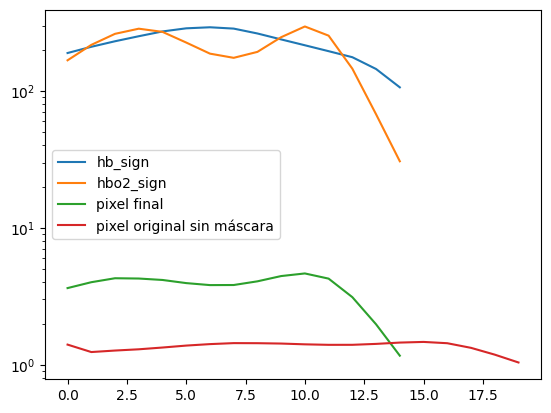

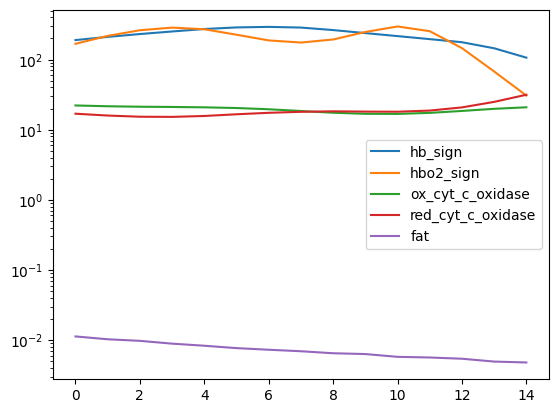

In [31]:
#muestro la firma espectral de hb_sign
plt.plot(hb_sign_new, label='hb_sign')
plt.plot(hbO2_sign_new, label='hbo2_sign')
# muestro también el píxel 100,200
#divido maskec_cube entre 10000
#masked_cube = masked_cube*10000
#filtered_data_absorbance = filtered_data_absorbance**4
plt.plot(masked_cube[100,200,:], label='pixel final')
plt.plot(filtered_data_absorbance[100,200,0:20], label='pixel original sin máscara')
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(hb_sign_new, label='hb_sign')
plt.plot(hbO2_sign_new, label='hbo2_sign')
plt.plot(ox_cyt_c_oxidase, label='ox_cyt_c_oxidase')
plt.plot(red_cyt_c_oxidase, label='red_cyt_c_oxidase')
plt.plot(fat, label='fat')
#plt.xlim(63, 124)
plt.yscale('log')
plt.legend()
plt.show()


# RECONSTRUCCIÓN 
[+] Comprobación de si es mejor la reconstrucción con más o menos elementos

[+] Medias:
    ab_hb   : 0.0008933633703390769
    ab_hbo2 : 0.003517358816617335
    ab_other: 0.0
    ab_ox   : 0.0
    ab_red  : 0.0
    ab_fat  : 0.0
    ab_carboxy: 1.603870738510176e-05
    ab_methoxy: 0.0
    ab_bilirubin: 0.0
    ab_sulfhemoglobin: 0.0
    ab_syn  : 0.2368222004644594
[+] Medias:
    ab_hb   : 0.009975144878840506
    ab_hbo2 : 0.0068142195124549585
    ab_other: 0.001163823553451722
    ab_ox   : 0.0
    ab_red  : 0.0
    ab_fat  : 0.0
    ab_carboxy: 0.0
    ab_methoxy: 0.0
    ab_bilirubin: 8.162781244746423e-05
    ab_sulfhemoglobin: 0.0
    ab_syn  : 0.7806707337389853
[+] Medias:
    ab_hb   : 0.0010878408609348888
    ab_hbo2 : 0.006992392988909211
    ab_other: 5.505723758374869e-05
    ab_ox   : 0.0
    ab_red  : 0.0
    ab_fat  : 0.0
    ab_carboxy: 6.771050948612884e-05
    ab_methoxy: 0.0
    ab_bilirubin: 0.0
    ab_sulfhemoglobin: 0.0
    ab_syn  : 0.696933496575456


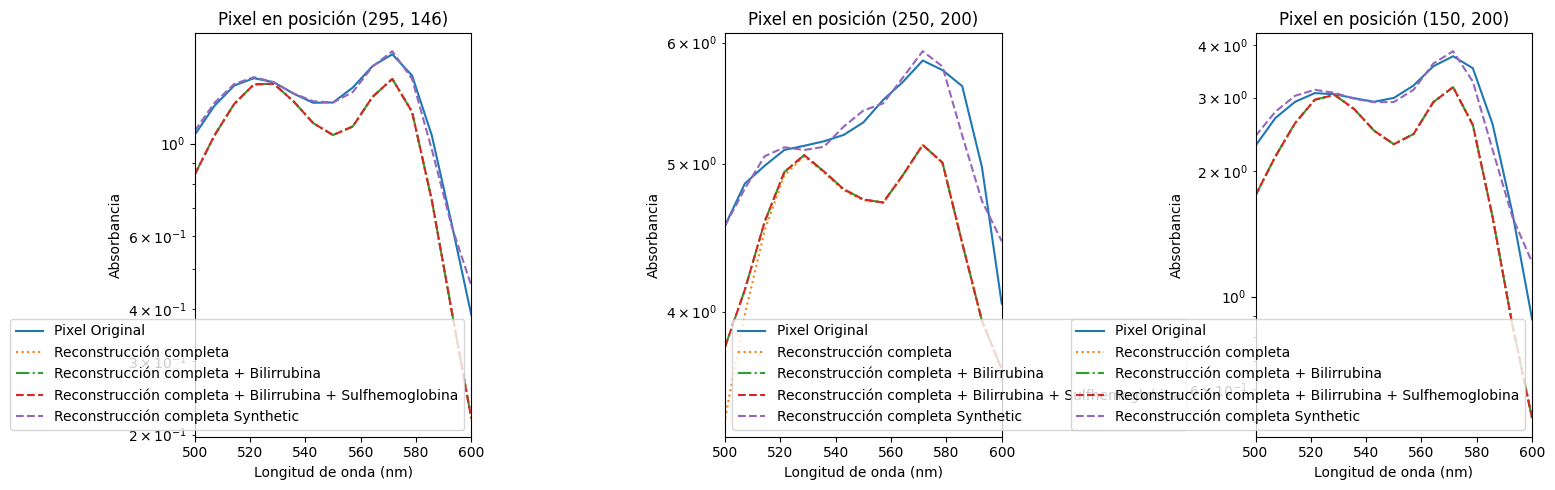

In [32]:
# Plotear las reconstrucciones de los píxeles junto a la firma
import matplotlib.pyplot as plt

# Seleccionar algunos píxeles para visualizar
pixels_to_plot = [(295, 146), (250, 200), (150, 200)]

# Crear una figura para los gráficos
plt.figure(figsize=(15, 5))

for idx, (i, j) in enumerate(pixels_to_plot):
    pixel = new_masked_cube[i, j, :]#/np.max(new_masked_cube[i, j, :])
    ab_hb_value = ab_hb[i, j]/np.max(ab_hb[i, j])    
    ab_hbo2_value = ab_hbo2[i, j]/np.max(ab_hbo2[i, j])
    ab_other_value = ab_other[i, j]/np.max(ab_other[i, j])
    
    # Reconstrucción del modelo
    model = (ab_hb[i, j] * hb_sign_new 
        + ab_hbo2[i, j] * hbO2_sign_new )
        #+ ab_other[i, j] * other_sign_new)
        
    # recosntrucción del modelo con agua
    model_agua = (ab_hb[i, j] * hb_sign_new
        + ab_hbo2[i, j] * hbO2_sign_new 
        + ab_other[i, j] * other_sign_new)
    
    # reconstrucción del modelo con agua y citocromos
    model_agua_cyt = (ab_hb[i, j] * hb_sign_new
        + ab_hbo2[i, j] * hbO2_sign_new 
        + ab_other[i, j] * other_sign_new
        + ab_ox[i,j] * ox_cyt_c_oxidase
        + ab_red[i,j] * red_cyt_c_oxidase)
    
    # reconstrucción del modelo con agua y citocromos y grasa
    model_water_and_cyt = (ab_hb[i, j] * hb_sign_new
        + ab_hbo2[i, j] * hbO2_sign_new 
        + ab_other[i, j] * other_sign_new
        + ab_ox[i,j] * ox_cyt_c_oxidase
        + ab_red[i,j] * red_cyt_c_oxidase
        + ab_fat[i,j] * fat)
    
    # reconstrucción del modelo con agua y citocromos y grasa y carboxihemoglobina y metoxihemoglobina
    model_full = (ab_hb[i, j] * hb_sign_new
        + ab_hbo2[i, j] * hbO2_sign_new 
        + ab_other[i, j] * other_sign_new
        + ab_ox[i,j] * ox_cyt_c_oxidase
        + ab_red[i,j] * red_cyt_c_oxidase
        + ab_fat[i,j] * fat
        + ab_carboxy[i,j] * interp_carboxyhemoglobin_sign
        + ab_methoxy[i,j] * interp_methoxyhemoglobin_sign)
    
    model_full_bilirubin = (ab_hb[i, j] * hb_sign_new
        + ab_hbo2[i, j] * hbO2_sign_new
        + ab_other[i, j] * other_sign_new
        + ab_ox[i,j] * ox_cyt_c_oxidase
        + ab_red[i,j] * red_cyt_c_oxidase
        + ab_fat[i,j] * fat
        + ab_carboxy[i,j] * interp_carboxyhemoglobin_sign
        + ab_methoxy[i,j] * interp_methoxyhemoglobin_sign
        + ab_bilirubin[i,j] * interp_bilirubin_sign)
    
    model_full_sulfhemoglobin = (ab_hb[i, j] * hb_sign_new
        + ab_hbo2[i, j] * hbO2_sign_new
        + ab_other[i, j] * other_sign_new
        + ab_ox[i,j] * ox_cyt_c_oxidase
        + ab_red[i,j] * red_cyt_c_oxidase
        + ab_fat[i,j] * fat
        + ab_carboxy[i,j] * interp_carboxyhemoglobin_sign
        + ab_methoxy[i,j] * interp_methoxyhemoglobin_sign
        + ab_bilirubin[i,j] * interp_bilirubin_sign
        + ab_sulfhemoglobin[i,j] * interp_sulfhemoglobin_sign)
    
    model_full_syn = (ab_hb[i, j] * hb_sign_new
        + ab_hbo2[i, j] * hbO2_sign_new
        + ab_other[i, j] * other_sign_new
        + ab_ox[i,j] * ox_cyt_c_oxidase
        + ab_red[i,j] * red_cyt_c_oxidase
        + ab_fat[i,j] * fat
        + ab_carboxy[i,j] * interp_carboxyhemoglobin_sign
        + ab_methoxy[i,j] * interp_methoxyhemoglobin_sign
        + ab_bilirubin[i,j] * interp_bilirubin_sign
        + ab_sulfhemoglobin[i,j] * interp_sulfhemoglobin_sign
        + ab_syn[i,j] * synthetic_sign)
    
    
    #print(hb_sign_new)
    # print(other_sign_new)
    
    # Plotear el pixel y la reconstrucción
    plt.subplot(1, len(pixels_to_plot), idx + 1)
    plt.plot(np.linspace(500, 600, len(pixel)), pixel, label='Pixel Original')
    #plt.plot(np.linspace(600, 1000, len(model)), model, label='Reconstrucción Sin Agua')
    # plt.plot(np.linspace(500, 600, len(model_agua)), model_agua, label='Reconstrucción Con Agua')
    # plt.plot(np.linspace(500, 600, len(model_water_and_cyt)), model_water_and_cyt, label='Reconstrucción agua y cyt y fat', linestyle='--')
    # plt.plot(np.linspace(500, 600, len(model_agua_cyt)), model_agua_cyt, label='Reconstrucción Con Agua y Citocromo', linestyle='-.')
    plt.plot(np.linspace(500, 600, len(model_full)), model_full, label='Reconstrucción completa', linestyle=':')
    plt.plot(np.linspace(500, 600, len(model_full_bilirubin)), model_full_bilirubin, label='Reconstrucción completa + Bilirrubina', linestyle='-.')
    plt.plot(np.linspace(500, 600, len(model_full_sulfhemoglobin)), model_full_sulfhemoglobin, label='Reconstrucción completa + Bilirrubina + Sulfhemoglobina', linestyle='--')
    plt.plot(np.linspace(500, 600, len(model_full_syn)), model_full_syn, label='Reconstrucción completa Synthetic', linestyle='--')
    
    
    # plt.plot(np.linspace(500, 600, len(hb_sign_new)), hb_sign_new, label='Hb')
    # plt.plot(np.linspace(500, 600, len(hbO2_sign_new)), hbO2_sign_new, label='HbO2')
    # plt.plot(np.linspace(600, 1000, len(other_sign_new)), other_sign_new, label='Other')
    
    plt.yscale('log')
    plt.title(f'Pixel en posición ({i}, {j})')
    plt.xlabel('Longitud de onda (nm)')
    plt.ylabel('Absorbancia')
    plt.xlim(500, 600)
    plt.legend()
    # muestro el valor medio que tiene cada una de las abundancias
    print("[+] Medias:")
    print(f"    ab_hb   : {np.mean(ab_hb[i, j])}")
    print(f"    ab_hbo2 : {np.mean(ab_hbo2[i, j])}")
    print(f"    ab_other: {np.mean(ab_other[i, j])}")
    print(f"    ab_ox   : {np.mean(ab_ox[i, j])}")
    print(f"    ab_red  : {np.mean(ab_red[i, j])}")
    print(f"    ab_fat  : {np.mean(ab_fat[i, j])}")
    print(f"    ab_carboxy: {np.mean(ab_carboxy[i, j])}")
    print(f"    ab_methoxy: {np.mean(ab_methoxy[i, j])}")
    print(f"    ab_bilirubin: {np.mean(ab_bilirubin[i, j])}")
    print(f"    ab_sulfhemoglobin: {np.mean(ab_sulfhemoglobin[i, j])}")
    print(f"    ab_syn  : {np.mean(ab_syn[i, j])}")

plt.tight_layout()
plt.show()

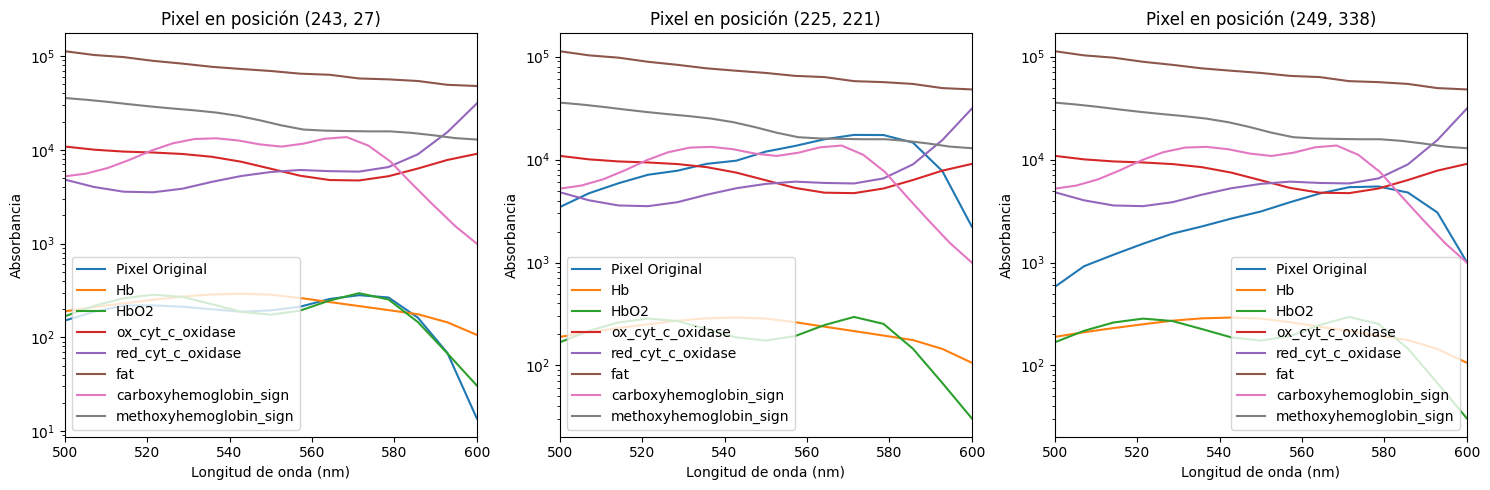

In [33]:
# Plotear las reconstrucciones de los píxeles junto a la firma
import matplotlib.pyplot as plt

# Seleccionar algunos píxeles para visualizar
pixels_to_plot = [
    (243, 27),
    (225, 221),
    (249, 338)
]

# Crear una figura para los gráficos
plt.figure(figsize=(15, 5))

for idx, (i, j) in enumerate(pixels_to_plot):
    pixel = new_masked_cube[i, j, :]#/np.max(new_masked_cube[i, j, :])
    ab_hb_value = ab_hb[i, j]/np.max(ab_hb[i, j])    
    ab_hbo2_value = ab_hbo2[i, j]/np.max(ab_hbo2[i, j])
    ab_other_value = ab_other[i, j]/np.max(ab_other[i, j])
    
    # Reconstrucción del modelo
    model = (ab_hb[i, j] * hb_sign_new 
        + ab_hbo2[i, j] * hbO2_sign_new )
        #+ ab_other[i, j] * other_sign_new)
    model2 = (ab_hb[i, j] * hb_sign_new
        + ab_hbo2[i, j] * hbO2_sign_new 
        + ab_other[i, j] * other_sign_new)
    #print(hb_sign_new)
    # print(other_sign_new)
    
    # Plotear el pixel y la reconstrucción
    plt.subplot(1, len(pixels_to_plot), idx + 1)
    plt.plot(np.linspace(500, 600, len(pixel)), pixel**5, label='Pixel Original')
    # plt.plot(np.linspace(600, 1000, len(model)), model, label='Reconstrucción Sin Agua')
    # plt.plot(np.linspace(600, 1000, len(model2)), model2, label='Reconstrucción Con Agua')
    
    plt.plot(np.linspace(500, 600, len(hb_sign_new)), hb_sign_new, label='Hb')
    plt.plot(np.linspace(500, 600, len(hbO2_sign_new)), hbO2_sign_new, label='HbO2')
    # plt.plot(np.linspace(600, 1000, len(other_sign_new)), other_sign_new, label='Other')
    plt.plot(np.linspace(500, 600, len(ox_cyt_c_oxidase)), ox_cyt_c_oxidase**3, label='ox_cyt_c_oxidase')
    plt.plot(np.linspace(500, 600, len(red_cyt_c_oxidase)), red_cyt_c_oxidase**3, label='red_cyt_c_oxidase')
    plt.plot(np.linspace(500, 600, len(fat)), fat*10000000, label='fat')
    plt.plot(np.linspace(500, 600, len(carboxyhemoglobin_sign)), carboxyhemoglobin_sign, label='carboxyhemoglobin_sign')
    plt.plot(np.linspace(500, 600, len(methoxyhemoglobin_sign)), methoxyhemoglobin_sign, label='methoxyhemoglobin_sign')
    
    plt.yscale('log')
    plt.title(f'Pixel en posición ({i}, {j})')
    plt.xlabel('Longitud de onda (nm)')
    plt.ylabel('Absorbancia')
    plt.xlim(500, 600)
    plt.legend()

plt.tight_layout()
plt.show()

## Mostrar niveles de Hb y HbO2

Abundancia Hb: min: 0.0 max: 0.029394876039068894
Abundancia HbO2: min: 0.0 max: 0.025740877412555242
Abundancia Agua: min: 0.0 max: 0.010305062628872427


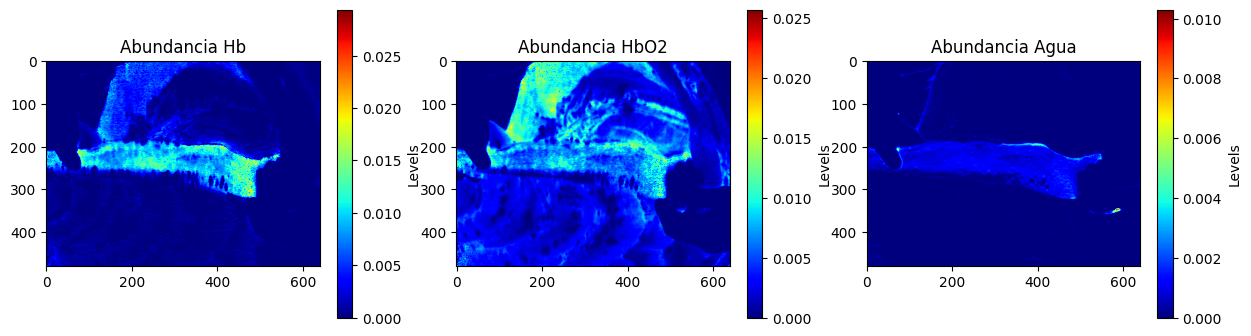

'plt.imshow(ab_bg[0]/ab_bg[0].max(), cmap="jet", vmin=0)\nplt.title("Abundancia Background")\nplt.show()'

In [34]:
# Visualizamos las abundancias
# muestro los máximos y mínimos de cada matriz
print("Abundancia Hb: min:", np.min(ab_hb), "max:", np.max(ab_hb))
print("Abundancia HbO2: min:", np.min(ab_hbo2), "max:", np.max(ab_hbo2))
print("Abundancia Agua: min:", np.min(ab_other), "max:", np.max(ab_other))
'''print("Abundancia Background: min:", np.min(ab_hbo2), "max:", np.min(ab_hbo2))'''



if (ab_hb.max() > ab_hbo2.max()):
    abmax = ab_hb.max()
else: abmax = ab_hbo2.max()
    

plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.imshow(ab_hb, cmap="jet", vmin=0, vmax=np.max(ab_hb))
plt.colorbar(label="Levels")
plt.title("Abundancia Hb")
plt.subplot(132)
plt.imshow(ab_hbo2, cmap="jet", vmin=0, vmax=np.max(ab_hbo2))
plt.colorbar(label="Levels")
plt.title("Abundancia HbO2")
plt.subplot(133)
plt.imshow(ab_other, cmap="jet", vmin=0, vmax=np.max(ab_other))
plt.colorbar(label="Levels")
plt.title("Abundancia Agua")
'''CHANGELOG.mdplt.subplot(144)
plt.imshow(ab_fat, cmap="jet", vmin=0, vmax=np.max(ab_fat))
plt.colorbar(label="Levels")
plt.title("Abundancia Fat")'''
plt.show()

# muestro la imagen de ab_background,
'''plt.imshow(ab_bg[0]/ab_bg[0].max(), cmap="jet", vmin=0)
plt.title("Abundancia Background")
plt.show()'''





## Mostrar niveles de StO2

media de ab_hb: 0.0016769770847210401
media de ab_hbo2: 0.003240625052157973
STO2: min: 0.0 max: 0.9999999931350875
(480, 640)
Error: 0.1957684660311749


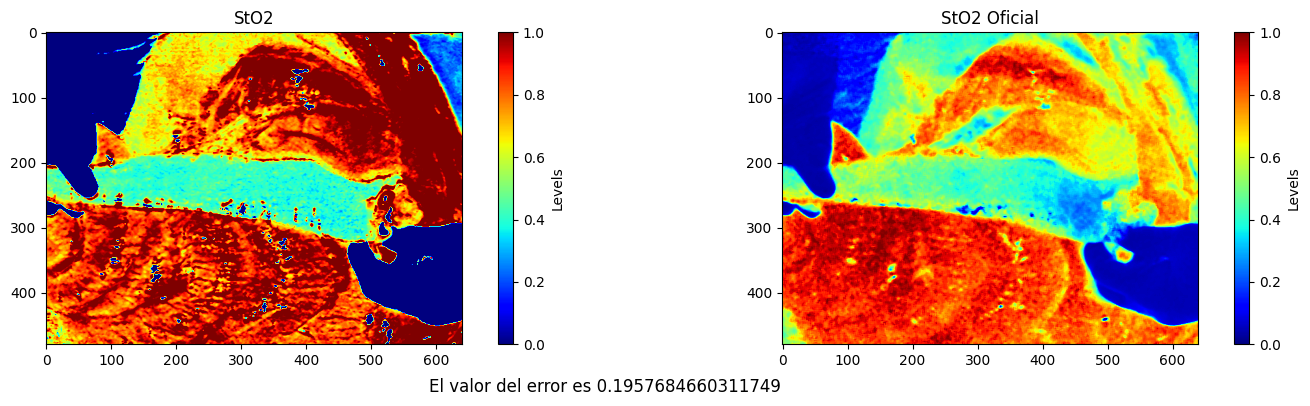

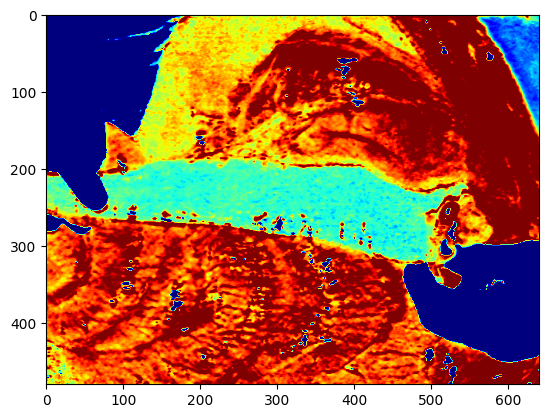

In [35]:
from scipy import ndimage

ab_hbo2 = ab_hbo2#/ab_hbo2.max()
ab_hb = ab_hb#/ab_hb.max()

print(f"media de ab_hb: {np.mean(ab_hb)}")
print(f"media de ab_hbo2: {np.mean(ab_hbo2)}")
#print(f"media de h2o: {np.mean(ab_other)}") 
epsilon = 1e-10  # Un valor pequeño para evitar el logaritmo de cero
# sto2 = (hbo2)/(hb + hbo2) * 100
sto2 = ((ab_hbo2) / (ab_hb + ab_hbo2+epsilon))

sto2 = ndimage.median_filter(sto2, size=3)

sto2 = np.nan_to_num(sto2, nan=0, posinf=0, neginf=0)

# mostramos los máximos y mínimos de la matriz de sto2
print("STO2: min:", sto2.min(), "max:", sto2.max())

# Visualizamos el STO2
'''print(sto2.shape)
plt.figure(figsize=(5, 5))
plt.imshow(sto2, cmap="jet", vmin=0.38, vmax=0.8)
plt.colorbar(label="STO2 Levels")
plt.title("STO2")
plt.show()'''

import numpy as np
def mse(img1, img2):
    # cuanto menor sea el valor, más se parecen entre sí las imagenes
    err = np.sum((img1.astype("float") - img2.astype("float")) ** 2)
    err /= float(img1.shape[0] * img1.shape[1])
    return err

def RMSE(img1, img2):
    # cuanto menor sea el valor, más se parecen entre sí las imagenes
    err = mse(img1, img2)
    return np.sqrt(err)


path = DataPath.from_image_name('P086#2021_04_15_09_22_02')
s_to2 = path.compute_sto2()
s_to2 = np.where(s_to2 == "--", 0, s_to2)

# muestro el shape de la imagen de sto2 y los valores de la primera fila de la imagen
print(s_to2.shape)

error = RMSE(sto2, s_to2)
print("Error:", error)

'''plt.figure(figsize=(5, 5))
plt.imshow(s_to2, cmap="jet", vmin=0, vmax=1)
plt.colorbar(label="STO2 Levels")
plt.title("STO2")
plt.show()
'''


plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.imshow(sto2, cmap="jet", vmin=0, vmax=1)
plt.colorbar(label="Levels")
plt.title("StO2")
plt.subplot(122)
plt.imshow(s_to2, cmap="jet", vmin=0, vmax=1)
plt.colorbar(label="Levels")
plt.title("StO2 Oficial")
plt.figtext(0.5, 0.02, f'El valor del error es {error}', ha='center', va='center', fontsize=12, color='black')



# Ajustar el layout para evitar solapamientos
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

plt.imshow(sto2, cmap="jet", vmin=0, vmax=1)
plt.savefig(os.path.join("/home/arturo.samayor/Practicas/NNs/resultImages", "sto2_comparison.png"), dpi=300, bbox_inches="tight")

In [36]:
import numpy as np

############## ARTURO ####################
def apply_mask_2d(img, mask):
    masked_data = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            masked_data[i, j] = np.where(mask[i, j], img[i, j], np.nan)
    return masked_data

def mse(img1, img2):
    # Convertir a tipo float
    arr1 = img1.astype(float)
    arr2 = img2.astype(float)
    
    # Crear máscara para ignorar NaN
    mask = ~np.isnan(arr1) & ~np.isnan(arr2)
    
    # Si no hay píxeles válidos, devolver NaN
    if not np.any(mask):
        return np.nan
    
    # Calcular el MSE sólo en los píxeles válidos
    err = np.sum((arr1[mask] - arr2[mask]) ** 2)
    err /= float(np.count_nonzero(mask))  # Normalizar por el número de píxeles válidos
    
    return err

def RMSE(img1, img2):
    # Cálculo del RMSE usando la función mse modificada
    err = mse(img1, img2)
    if np.isnan(err):
        return np.nan
    
    return np.sqrt(err)

def calculate_psnr(img1, img2, max_value=1):
    # Convertir las imágenes a float32
    arr1 = np.array(img1, dtype=np.float32)
    arr2 = np.array(img2, dtype=np.float32)
    
    # Crear una máscara que ignore los NaN
    # Esta máscara será True sólo donde no hay NaN en ninguna de las dos imágenes
    mask = ~np.isnan(arr1) & ~np.isnan(arr2)
    
    # Si no hay elementos válidos, no se puede calcular el PSNR
    if not np.any(mask):
        return float('nan')
    
    # Calcular el MSE sólo en los píxeles válidos
    mse = np.mean((arr1[mask] - arr2[mask]) ** 2)
    
    # Si el MSE es cero, significa que las imágenes son idénticas en la región válida
    if mse == 0:
        return 100.0
    
    # Calcular el PSNR
    psnr = 20 * np.log10(max_value / np.sqrt(mse))
    return psnr

############## ARTURO ####################


# Ejemplo de uso:
#sto2 = np.array([[0, 0.5, 0.6], [0.3, 0, 0.4], [0.2, 0.1, 0]])  # Ejemplo de imagen 1
#s_to2 = np.array([[0, 0.4, 0.7], [0.2, 0, 0.5], [0.3, 0.1, 0]])  # Ejemplo de imagen 2

# Calcular el RMSE ignorando píxeles con valor 0
#################### ARTURO ####################
sto2ar = apply_mask_2d(sto2, full_mask)
s_to2ar = apply_mask_2d(s_to2, full_mask)
errorAr = RMSE(sto2ar, s_to2ar)
errorPSNRar = calculate_psnr(sto2ar, s_to2ar)
print("#################### ARTURO ####################")
print("Error RMSE (ignorando píxeles 0):", errorAr)
print("valor maximo de la imagen:", np.max(sto2ar))
print("valor maximo de la imagen_:", np.max(s_to2ar))
print("Error PSNR:", errorPSNRar)
print("#################### ARTURO ####################")
#################### ARTURO ####################

############## ALEJANDRO ####################
def MSE(x, y):
    return np.mean(np.nan_to_num((x - y) ** 2))
def PSNR(x, y):
    return 10 * np.log10(1 / MSE(x, y))

error = RMSE(sto2, s_to2)
error2 = PSNR(sto2, s_to2)
print("#################### ALEJANDRO ####################")
print("\nError RMSE (ignorando píxeles 0):", error)
print("valor maximo de la imagen:", np.max(sto2))
print("valor maximo de la imagen_:", np.max(s_to2))
print("Error PSNR:", error2)
print("#################### ALEJANDRO ####################")
############## ALEJANDRO ####################


#################### ARTURO ####################
Error RMSE (ignorando píxeles 0): 0.20203303932998842
valor maximo de la imagen: nan
valor maximo de la imagen_: nan
Error PSNR: 13.891552
#################### ARTURO ####################
#################### ALEJANDRO ####################

Error RMSE (ignorando píxeles 0): 0.1957684660311749
valor maximo de la imagen: 0.9999999931350875
valor maximo de la imagen_: 1.0
Error PSNR: 14.16514524264711
#################### ALEJANDRO ####################


# VER LAS FIRMAS ESPECTRALES DE CADA PÍXEL (218, 52), (225, 221), (249, 338)

Valor de ox_cyt_c_oxidase en el pixel 243 27 : 0.0
Valor de red_cyt_c_oxidase en el pixel 243 27 : 0.0
Valor de agua en el pixel 243 27 : 0.0003645641181407284
Valor de hb_sign_new en el pixel 243 27 : 0.0050296565000182165
Valor de hbo2_sign_new en el pixel 243 27 : 0.004305015874835037 



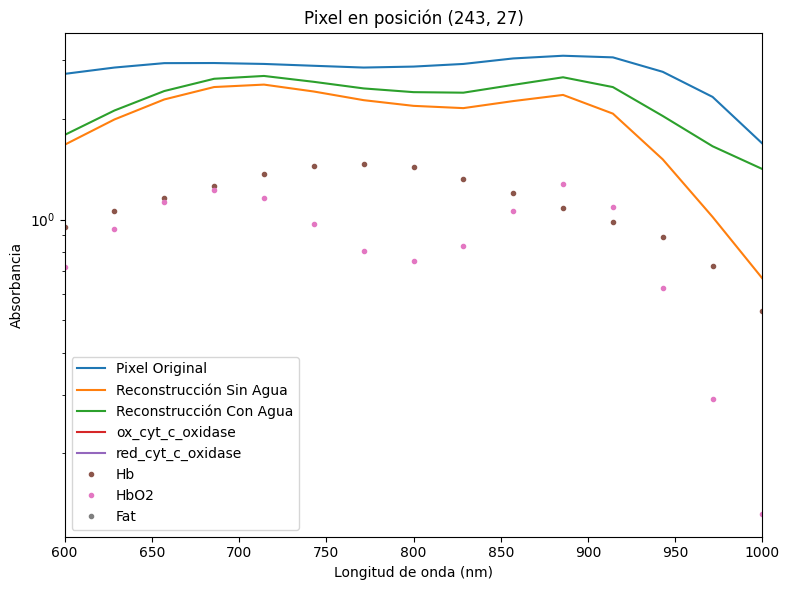

Valor de ox_cyt_c_oxidase en el pixel 225 221 : 0.0
Valor de red_cyt_c_oxidase en el pixel 225 221 : 0.0
Valor de agua en el pixel 225 221 : 0.0013013529704473236
Valor de hb_sign_new en el pixel 225 221 : 0.011819946107193493
Valor de hbo2_sign_new en el pixel 225 221 : 0.007324322671145397 



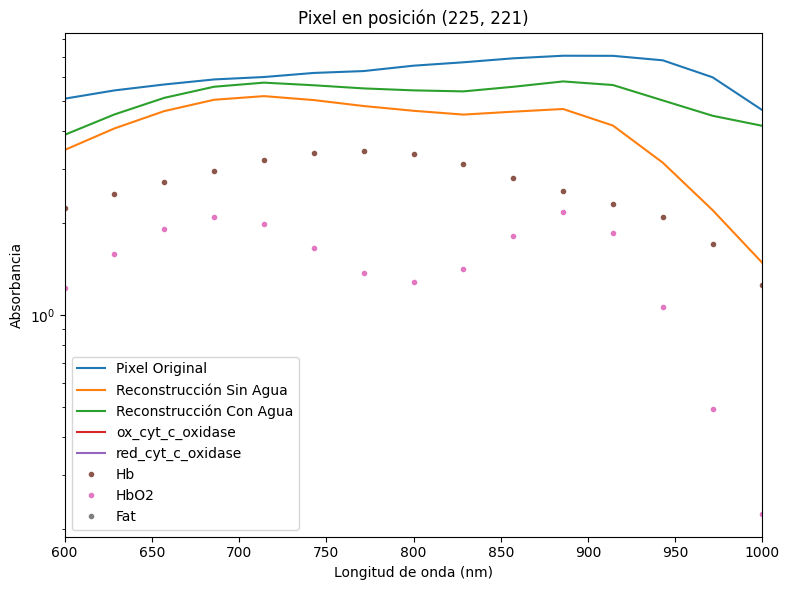

Valor de ox_cyt_c_oxidase en el pixel 249 338 : 0.0
Valor de red_cyt_c_oxidase en el pixel 249 338 : 0.0
Valor de agua en el pixel 249 338 : 0.0013679381899584678
Valor de hb_sign_new en el pixel 249 338 : 0.006722914795371869
Valor de hbo2_sign_new en el pixel 249 338 : 0.004832007719930516 



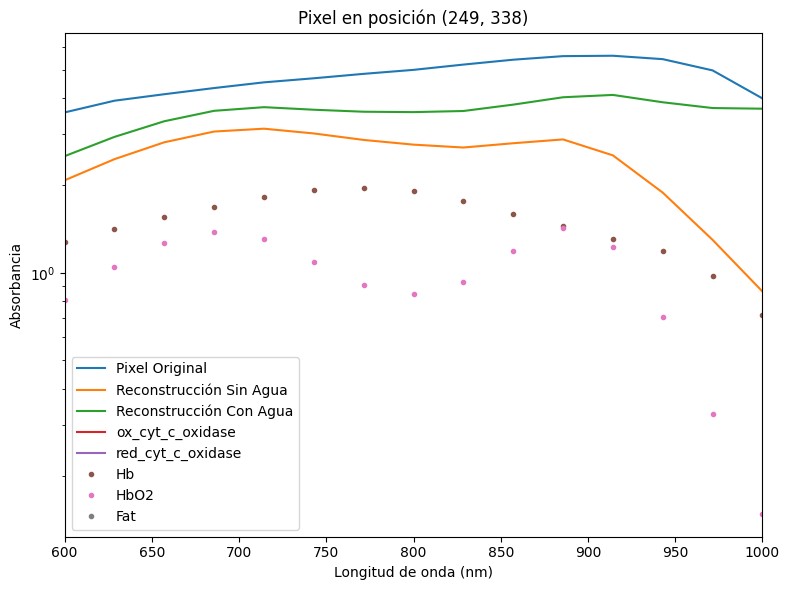

In [37]:
import matplotlib.pyplot as plt

pixels_to_plot = [
    (243, 27),
    (225, 221),
    (249, 338)
]

for idx, (i, j) in enumerate(pixels_to_plot):
    pixel = new_masked_cube[i, j, :]
    # Reconstrucción del modelo
    model = ab_hb[i, j] * hb_sign_new + ab_hbo2[i, j] * hbO2_sign_new
    model2 = (ab_hb[i, j] * hb_sign_new +
              ab_hbo2[i, j] * hbO2_sign_new +
              ab_other[i, j] * other_sign_new)
    
    plt.figure(figsize=(8,6))
    plt.plot(np.linspace(600, 1000, len(pixel)), pixel, label='Pixel Original')
    plt.plot(np.linspace(600, 1000, len(model)), model, label='Reconstrucción Sin Agua')
    plt.plot(np.linspace(600, 1000, len(model2)), model2, label='Reconstrucción Con Agua')

    plt.plot(np.linspace(600, 1000, len(ox_cyt_c_oxidase)), ox_cyt_c_oxidase*ab_ox[i,j], label='ox_cyt_c_oxidase')
    plt.plot(np.linspace(600, 1000, len(red_cyt_c_oxidase)), red_cyt_c_oxidase*ab_red[i,j], label='red_cyt_c_oxidase')
    plt.plot(np.linspace(600, 1000, len(hb_sign_new)), hb_sign_new*ab_hb[i,j], marker='.', linestyle='', label='Hb')
    plt.plot(np.linspace(600, 1000, len(hbO2_sign_new)), hbO2_sign_new*ab_hbo2[i,j], marker='.', linestyle='', label='HbO2')
    # el fat
    plt.plot(np.linspace(600, 1000, len(fat)), fat*ab_fat[i,j], marker='.', linestyle='', label='Fat')
    # plt.plot(np.linspace(600, 1000, len(other_sign_new)), (other_sign_new*ab_other[i,j])/10000, marker='.', linestyle='', label='Other')
    
    print("Valor de ox_cyt_c_oxidase en el pixel", i, j, ":", ab_ox[i,j])
    print("Valor de red_cyt_c_oxidase en el pixel", i, j, ":", ab_red[i,j])
    print("Valor de agua en el pixel", i, j, ":", ab_other[i,j])
    print("Valor de hb_sign_new en el pixel", i, j, ":", ab_hb[i,j])
    print("Valor de hbo2_sign_new en el pixel", i, j, ":", ab_hbo2[i,j], "\n")
    
    
    plt.yscale('log')
    plt.title(f'Pixel en posición ({i}, {j})')
    plt.xlabel('Longitud de onda (nm)')
    plt.ylabel('Absorbancia')
    plt.xlim(600, 1000)
    plt.legend()
    plt.tight_layout()
    plt.show()
